# Race and Home Ownership

This is a deeper local analysis of some of the data from an [NJISJ report](https://njisj.org/reports/stateofinequity/) on Essex County
as reported in an [NJ Patch](https://patch.com/new-jersey/maplewood/s/iv2ag/essex-county-has-some-of-worst-racial-wealth-gaps-in-new-jersey-study?utm_source=local-update&utm_medium=email&utm_campaign=alert) article.

## Imports, Definitions, and Setup

In [1]:
import censusdis.data as ced

from censusdis.datasets import ACS5

from censusdis.states import NJ
from censusdis.counties.new_jersey import ATLANTIC, BURLINGTON, ESSEX, HUDSON, PASSAIC

import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

from matplotlib.ticker import FuncFormatter, PercentFormatter

In [2]:
# These are the groups that count households by tenure and race/ethicity.

TENURE_GROUP_ALL = "B25003"
TENURE_GROUP_WHITE = "B25003H"
TENURE_GROUP_BLACK = "B25003B"
TENURE_GROUP_HISPANIC_LATINO = "B25003I"

TENURE_GROUPS = {
    "Overall": TENURE_GROUP_ALL,
    "White": TENURE_GROUP_WHITE,
    "Black": TENURE_GROUP_BLACK,
    "Latina/o": TENURE_GROUP_HISPANIC_LATINO,
}

SUFFIX_TOTAL = "_001E"
SUFFIX_OWNER_OCCUPIED = "_002E"
SUFFIX_RENTER_OCCUPIED = "_003E"

VARIABLE_SUFFIXES = {
    "Total": SUFFIX_TOTAL,
    "Owner Occupied": SUFFIX_OWNER_OCCUPIED,
    "Renter Occupied": SUFFIX_RENTER_OCCUPIED,
}

In [3]:
ALL_VARIABLES_BY_GROUP = {
    group_name: {
        f"{group}{suffix}": f"{suffix_name}"
        for suffix_name, suffix in VARIABLE_SUFFIXES.items()
    }
    for group_name, group in TENURE_GROUPS.items()
}

ALL_VARIABLES_BY_GROUP

{'Overall': {'B25003_001E': 'Total',
  'B25003_002E': 'Owner Occupied',
  'B25003_003E': 'Renter Occupied'},
 'White': {'B25003H_001E': 'Total',
  'B25003H_002E': 'Owner Occupied',
  'B25003H_003E': 'Renter Occupied'},
 'Black': {'B25003B_001E': 'Total',
  'B25003B_002E': 'Owner Occupied',
  'B25003B_003E': 'Renter Occupied'},
 'Latina/o': {'B25003I_001E': 'Total',
  'B25003I_002E': 'Owner Occupied',
  'B25003I_003E': 'Renter Occupied'}}

In [4]:
ALL_VARIABLES_BY_GROUP_AND_TENURE = {
    group_name: {
        f"{suffix_name}": f"{group}{suffix}"
        for suffix_name, suffix in VARIABLE_SUFFIXES.items()
    }
    for group_name, group in TENURE_GROUPS.items()
}

ALL_VARIABLES_BY_GROUP_AND_TENURE

{'Overall': {'Total': 'B25003_001E',
  'Owner Occupied': 'B25003_002E',
  'Renter Occupied': 'B25003_003E'},
 'White': {'Total': 'B25003H_001E',
  'Owner Occupied': 'B25003H_002E',
  'Renter Occupied': 'B25003H_003E'},
 'Black': {'Total': 'B25003B_001E',
  'Owner Occupied': 'B25003B_002E',
  'Renter Occupied': 'B25003B_003E'},
 'Latina/o': {'Total': 'B25003I_001E',
  'Owner Occupied': 'B25003I_002E',
  'Renter Occupied': 'B25003I_003E'}}

In [5]:
ALL_VARIABLES = {
    f"{group_name} {suffix_name}": f"{group}{suffix}"
    for group_name, group in TENURE_GROUPS.items()
    for suffix_name, suffix in VARIABLE_SUFFIXES.items()
}

ALL_VARIABLES

{'Overall Total': 'B25003_001E',
 'Overall Owner Occupied': 'B25003_002E',
 'Overall Renter Occupied': 'B25003_003E',
 'White Total': 'B25003H_001E',
 'White Owner Occupied': 'B25003H_002E',
 'White Renter Occupied': 'B25003H_003E',
 'Black Total': 'B25003B_001E',
 'Black Owner Occupied': 'B25003B_002E',
 'Black Renter Occupied': 'B25003B_003E',
 'Latina/o Total': 'B25003I_001E',
 'Latina/o Owner Occupied': 'B25003I_002E',
 'Latina/o Renter Occupied': 'B25003I_003E'}

In [6]:
ALL_VARIABLE_NAMES = {v: k for k, v in ALL_VARIABLES.items()}

In [7]:
def add_ownership_rates(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for group_name, group in TENURE_GROUPS.items():
        for suffix_name, suffix in VARIABLE_SUFFIXES.items():
            if suffix != SUFFIX_TOTAL:
                df[f"{group_name} {suffix_name} Fraction"] = (
                    df[f"{group}{suffix}"] / df[f"{group}{SUFFIX_TOTAL}"]
                )

    return df

## Download the Census Data

In [8]:
def data_for(group_name, **kwargs) -> pd.DataFrame:
    gdf = ced.download(
        dataset=ACS5,
        vintage=2022,
        download_variables=["NAME"] + list(ALL_VARIABLES_BY_GROUP[group_name].keys()),
        with_geometry=True,
        **kwargs
    )

    gdf.insert(len(kwargs) + 1, "GROUP", group_name)

    gdf.rename(ALL_VARIABLES_BY_GROUP[group_name], axis="columns", inplace=True)

    return gdf


def add_fractions(df: pd.DataFrame) -> pd.DataFrame:
    df["Owner Fraction"] = df["Owner Occupied"] / df["Total"]
    df["Renter Fraction"] = df["Renter Occupied"] / df["Total"]
    return df

In [9]:
gdf_county = gpd.GeoDataFrame(
    pd.concat(
        [data_for(group_name, state=NJ, county="*") for group_name in TENURE_GROUPS]
    ).reset_index(drop=True)
)

gdf_county = add_fractions(gdf_county)

In [10]:
gdf_county

,STATE,COUNTY,NAME,GROUP,Total,Owner Occupied,Renter Occupied,geometry,Owner Fraction,Renter Fraction
0,34,001,"Atlantic County, New Jersey",Overall,106640,72378,34262,"POLYGON ((-74.98527 39.51497, -74.95626 39.540...",0.678713,0.321287
1,34,003,"Bergen County, New Jersey",Overall,350843,228445,122398,"POLYGON ((-74.27066 41.02103, -74.25046 41.060...",0.651132,0.348868
2,34,005,"Burlington County, New Jersey",Overall,174454,132314,42140,"POLYGON ((-75.05965 39.99215, -75.05809 39.997...",0.758446,0.241554
3,34,007,"Camden County, New Jersey",Overall,198757,130036,68721,"POLYGON ((-75.13730 39.88997, -75.13541 39.893...",0.654246,0.345754
4,34,009,"Cape May County, New Jersey",Overall,43277,33950,9327,"POLYGON ((-74.97191 38.94058, -74.97043 38.944...",0.784481,0.215519
...,...,...,...,...,...,...,...,...,...,...
79,34,033,"Salem County, New Jersey",Latina/o,1930,924,1006,"MULTIPOLYGON (((-75.41272 39.38437, -75.41130 ...",0.478756,0.521244
80,34,035,"Somerset County, New Jersey",Latina/o,15894,7264,8630,"POLYGON ((-74.79582 40.51527, -74.79400 40.514...",0.457028,0.542972
81,34,037,"Sussex County, New Jersey",Latina/o,4388,3491,897,"POLYGON ((-74.99172 41.09228, -74.98221 41.108...",0.795579,0.204421
82,34,039,"Union County, New Jersey",Latina/o,57374,21180,36194,"POLYGON ((-74.45988 40.60003, -74.45738 40.602...",0.369157,0.630843


## Compare to NJISJ Numbers

### NJISJ Figure 1

In [11]:
def plot_under_50(gdf, color, **kwargs):

    ax = gdf[gdf["Owner Fraction"] < 0.5].plot(color=color, **kwargs)

    ax = gdf.boundary.plot(color="black", ax=ax)

    for _, row in gdf.iterrows():
        rep = row["geometry"].representative_point()

        name = row["NAME"].split(" County, ")[0]

        ax.text(
            rep.x,
            rep.y,
            f"{name}",
            ha="center",
            va="center",
            color="#333",
            size=9,
            path_effects=[pe.withStroke(linewidth=4, foreground="white")],
        )

    ax.set_axis_off()

    return ax

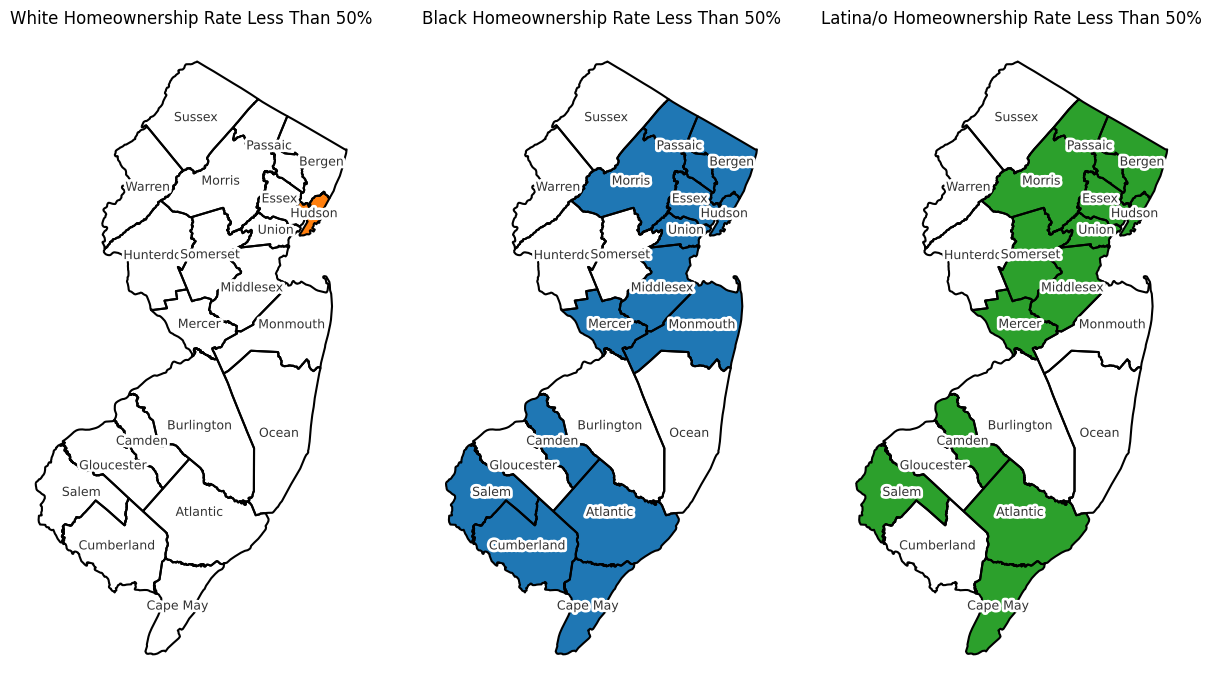

In [12]:
figs, axes = plt.subplots(1, 3, figsize=(15, 10))

ax = plot_under_50(gdf_county[gdf_county["GROUP"] == "White"], "C1", ax=axes[0])
ax.set_title("White Homeownership Rate Less Than 50%")

ax = plot_under_50(gdf_county[gdf_county["GROUP"] == "Black"], "C0", ax=axes[1])
ax.set_title("Black Homeownership Rate Less Than 50%")


ax = plot_under_50(gdf_county[gdf_county["GROUP"] == "Latina/o"], "C2", ax=axes[2])
_ = ax.set_title("Latina/o Homeownership Rate Less Than 50%")

Compare to Figure 3 of the [NJISJ Report](https://njisj.org/reports/stateofinequity/).

### NJISJ Figure 2

In [13]:
gdf_five_counties = gdf_county[
    gdf_county["COUNTY"].isin([ATLANTIC, BURLINGTON, ESSEX, HUDSON, PASSAIC])
]

In [14]:
df_county_plot = gdf_five_counties[gdf_five_counties["GROUP"] != "Overall"][
    ["NAME", "GROUP", "Owner Fraction"]
].pivot(index="NAME", columns=["GROUP"])

df_county_plot = df_county_plot[
    [
        ("Owner Fraction", "White"),
        ("Owner Fraction", "Black"),
        ("Owner Fraction", "Latina/o"),
    ]
]

df_county_plot = df_county_plot.reset_index()

df_county_plot["NAME"] = df_county_plot["NAME"].apply(lambda c: c.split(",")[0])

df_county_plot.set_index("NAME", inplace=True)

df_county_plot.columns = [c[1] for c in df_county_plot.columns]

df_county_plot

,White,Black,Latina/o
NAME,,,
Atlantic County,0.788045,0.421249,0.414616
Burlington County,0.809857,0.628063,0.609060
Essex County,0.683768,0.282469,0.339738
Hudson County,0.408360,0.254909,0.244391
Passaic County,0.741666,0.273852,0.304831


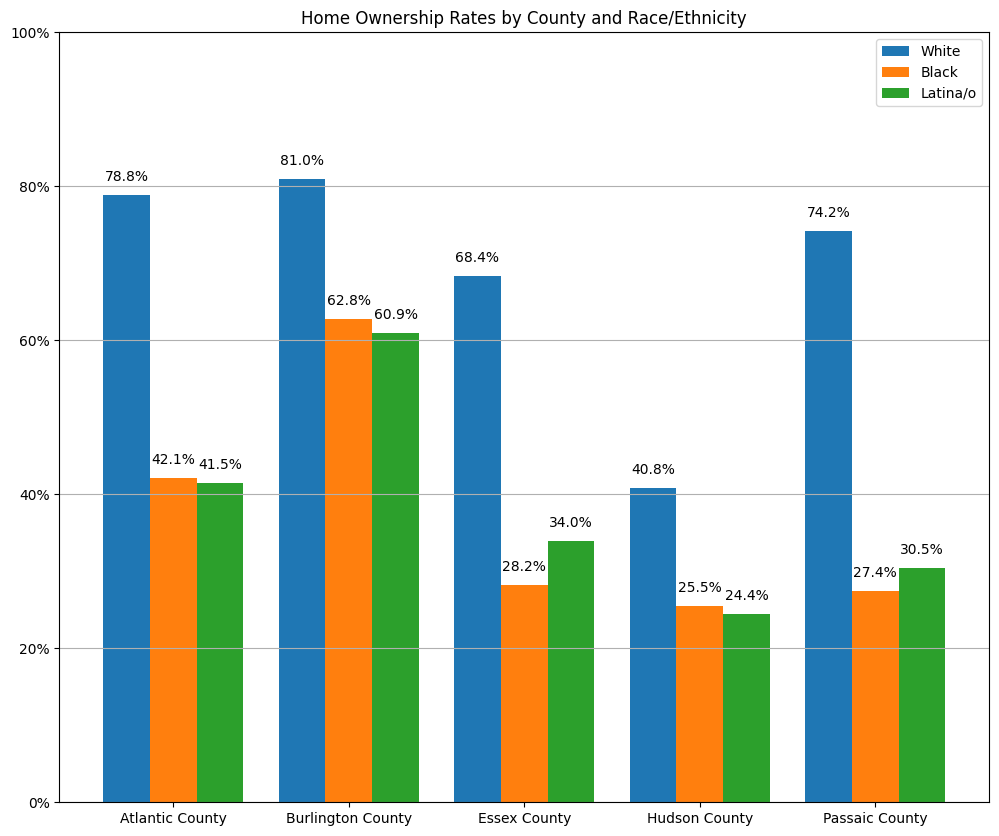

In [15]:
ax = df_county_plot.plot.bar(width=0.8, figsize=(12, 10))

for container in ax.containers:
    ax.bar_label(container, fmt=lambda x: f"{100 * x:,.1f}%", padding=8)

ax.set_title("Home Ownership Rates by County and Race/Ethnicity")

ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_ylim(0, 1.0)
ax.yaxis.grid()

ax.set_xticklabels(df_county_plot.index, rotation=0)
_ = ax.set_xlabel(None)

### NJISJ Figure 3

In [16]:
GROUP_ORDER = {"Latina/o": 0, "Black": 1, "White": 2}


def plot_hbar(df: pd.DataFrame, title: str, round100: bool = False):
    df_plot = df[df["GROUP"] != "Overall"][["GROUP", "Total", "Owner Occupied"]]

    df_plot["GROUP_ORDER"] = df_plot["GROUP"].map(GROUP_ORDER)
    df_plot = df_plot.sort_values(by="GROUP_ORDER", ascending=False)
    df_plot = df_plot.drop("GROUP_ORDER", axis="columns")

    ax = df_plot.plot.barh("GROUP")

    for container in ax.containers:
        if round100:
            ax.bar_label(
                container, fmt=lambda x: f"{100 * round(x / 100):,.0f}", padding=4
            )
        else:
            ax.bar_label(container, fmt=lambda x: f"{x:,.0f}", padding=4)

    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f"{x:,.0f}"))
    ax.xaxis.grid()

    ax.set_ylabel(None)
    ax.set_title(title)

    return ax

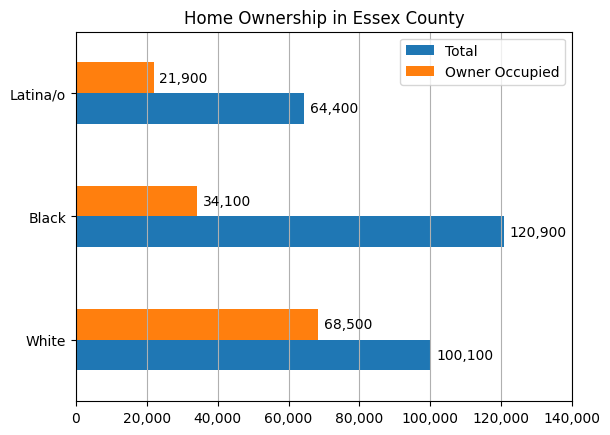

In [17]:
ax = plot_hbar(
    gdf_county[gdf_county["COUNTY"] == ESSEX],
    "Home Ownership in Essex County",
    round100=True,
)
_ = ax.set_xlim(0, 140_000)

In [18]:
df_county_plot

,White,Black,Latina/o
NAME,,,
Atlantic County,0.788045,0.421249,0.414616
Burlington County,0.809857,0.628063,0.609060
Essex County,0.683768,0.282469,0.339738
Hudson County,0.408360,0.254909,0.244391
Passaic County,0.741666,0.273852,0.304831


## SoMa

In [19]:
df_soma_zips = pd.concat(
    [
        data_for(group_name, zip_code_tabulation_area=["07079", "07040"])
        for group_name in TENURE_GROUPS
    ]
).reset_index(drop=True)

df_soma_zips = add_fractions(df_soma_zips)

In [20]:
df_soma_zips.sort_values(by=["NAME", "GROUP"])

,ZIP_CODE_TABULATION_AREA,NAME,GROUP,Total,Owner Occupied,Renter Occupied,geometry,Owner Fraction,Renter Fraction
4,07040,ZCTA5 07040,Black,2507,1645,862,"POLYGON ((-74.29305 40.75222, -74.29302 40.752...",0.656163,0.343837
6,07040,ZCTA5 07040,Latina/o,367,261,106,"POLYGON ((-74.29305 40.75222, -74.29302 40.752...",0.711172,0.288828
0,07040,ZCTA5 07040,Overall,8401,6467,1934,"POLYGON ((-74.29305 40.75222, -74.29302 40.752...",0.769789,0.230211
2,07040,ZCTA5 07040,White,4970,4185,785,"POLYGON ((-74.29305 40.75222, -74.29302 40.752...",0.842052,0.157948
5,07079,ZCTA5 07079,Black,1283,835,448,"POLYGON ((-74.28311 40.74787, -74.28234 40.748...",0.650818,0.349182
7,07079,ZCTA5 07079,Latina/o,278,213,65,"POLYGON ((-74.28311 40.74787, -74.28234 40.748...",0.766187,0.233813
1,07079,ZCTA5 07079,Overall,5863,3842,2021,"POLYGON ((-74.28311 40.74787, -74.28234 40.748...",0.655296,0.344704
3,07079,ZCTA5 07079,White,3822,2543,1279,"POLYGON ((-74.28311 40.74787, -74.28234 40.748...",0.665358,0.334642


In [21]:
df_soma = (
    df_soma_zips.groupby("GROUP")[["Total", "Owner Occupied", "Renter Occupied"]]
    .sum()
    .reset_index()
)
df_soma["NAME"] = "SoMa"
df_soma = add_fractions(df_soma)

df_soma

,GROUP,Total,Owner Occupied,Renter Occupied,NAME,Owner Fraction,Renter Fraction
0,Black,3790,2480,1310,SoMa,0.654354,0.345646
1,Latina/o,645,474,171,SoMa,0.734884,0.265116
2,Overall,14264,10309,3955,SoMa,0.722729,0.277271
3,White,8792,6728,2064,SoMa,0.765241,0.234759


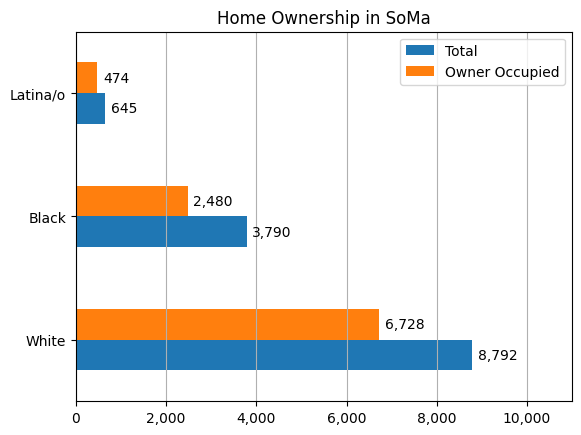

In [22]:
ax = plot_hbar(df_soma, "Home Ownership in SoMa")
_ = ax.set_xlim(0, 11_000)

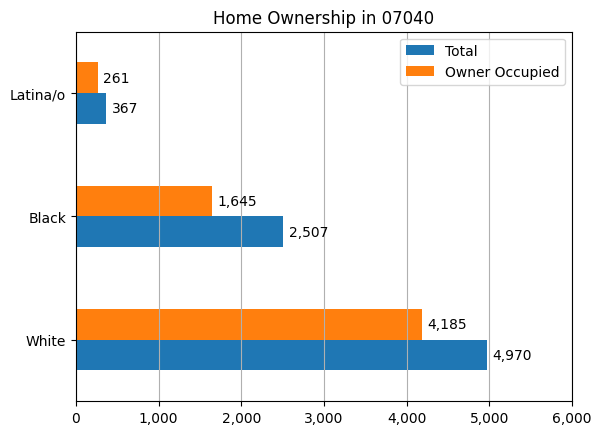

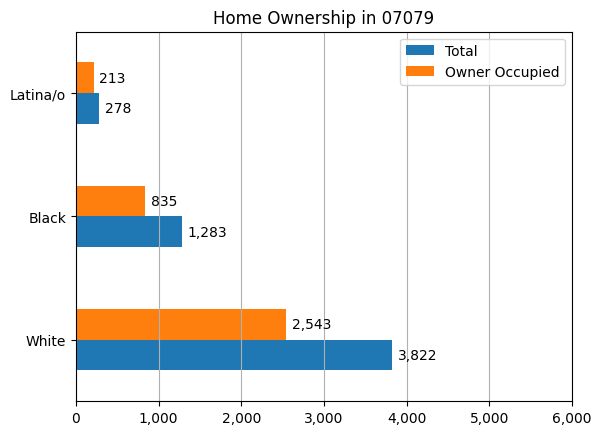

In [23]:
for zcta, df_zip in df_soma_zips.groupby("ZIP_CODE_TABULATION_AREA"):
    ax = plot_hbar(df_zip, f"Home Ownership in {zcta}")
    _ = ax.set_xlim(0, 6_000)

## Save to CSV

Put all the data into one csv.

In [24]:
df_csv = (
    pd.concat([gdf_county, df_soma_zips, df_soma])[
        [
            col
            for col in gdf_county.columns
            if col not in ["STATE", "COUNTY", "geometry"]
        ]
    ]
    .reset_index(drop=True)
    .rename(ALL_VARIABLE_NAMES, axis="columns")
)

df_csv.sort_values(by=["NAME", "GROUP"], inplace=True)

df_csv

,NAME,GROUP,Total,Owner Occupied,Renter Occupied,Owner Fraction,Renter Fraction
42,"Atlantic County, New Jersey",Black,13911,5860,8051,0.421249,0.578751
63,"Atlantic County, New Jersey",Latina/o,15846,6570,9276,0.414616,0.585384
0,"Atlantic County, New Jersey",Overall,106640,72378,34262,0.678713,0.321287
21,"Atlantic County, New Jersey",White,67236,52985,14251,0.788045,0.211955
43,"Bergen County, New Jersey",Black,20890,9226,11664,0.441647,0.558353
...,...,...,...,...,...,...,...
86,ZCTA5 07040,White,4970,4185,785,0.842052,0.157948
89,ZCTA5 07079,Black,1283,835,448,0.650818,0.349182
91,ZCTA5 07079,Latina/o,278,213,65,0.766187,0.233813
85,ZCTA5 07079,Overall,5863,3842,2021,0.655296,0.344704


In [25]:
df_csv.to_csv("home_ownership.csv", index=False)